In [1]:
# Import necessary modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

sys.path.insert(0, '..')

from core.model.model_disturbances import ModelDisturbances
from core.model.model_typical_disturbances import ModelTypicalDisturbances
from core.model.model_sensitivities import ModelSensitivities
from core.plotting.plotting import *

## Example raw and delayed fertilizer with different sigma_F

In [2]:
df = pd.read_csv(
    '../io/inputs/delayed_fertilizer_absorption_sensitivity.csv'
)

In [3]:
# Read-in the different traces
raw_fertilizer = df['Raw Fertilizer (lbs/hr)']
delayed_fertilizer_sigmaF_100 = df['Delayed Fertilizer, sigma_F=100 (lbs/hr)']
delayed_fertilizer_sigmaF_200 = df['Delayed Fertilizer, sigma_F=200 (lbs/hr)']
delayed_fertilizer_sigmaF_300 = df['Delayed Fertilizer, sigma_F=300 (lbs/hr)']

## Calculate cumulative fertilizer absorbed for each sigma_F value

In [4]:
cumulative_fertilizer_sigmaF_100 = np.cumsum(delayed_fertilizer_sigmaF_100)
cumulative_fertilizer_sigmaF_200 = np.cumsum(delayed_fertilizer_sigmaF_200)
cumulative_fertilizer_sigmaF_300 = np.cumsum(delayed_fertilizer_sigmaF_300)

In [5]:
time = np.arange(len(raw_fertilizer))
default_typical_disturbances = ModelTypicalDisturbances()
F_typ = default_typical_disturbances.typical_fertilizer * 0.1 # 0.1 was the dt used to get the input CSV values
expected_cumulative_fertilizer = F_typ * time

## Calculate the difference between the expected and actual cumulative values ("anomaly" values)

In [6]:
model_sensitivities = ModelSensitivities()
epsilon = model_sensitivities.epsilon
fertilizer_anomaly_sigmaF_100 = np.abs((expected_cumulative_fertilizer - cumulative_fertilizer_sigmaF_100) / expected_cumulative_fertilizer)
fertilizer_anomaly_sigmaF_200 = np.abs((expected_cumulative_fertilizer - cumulative_fertilizer_sigmaF_200) / expected_cumulative_fertilizer)
fertilizer_anomaly_sigmaF_300 = np.abs((expected_cumulative_fertilizer - cumulative_fertilizer_sigmaF_300) / expected_cumulative_fertilizer)

## Calculate the EMA-smoothed cumulative anomaly

In [7]:
#beta_divergence = model_sensitivities.beta_divergence
beta_divergence = 0.99998 # use a different value that exaggerates the effect for demonstration

fertilizer_divergence_sigmaF_100 = np.zeros_like(fertilizer_anomaly_sigmaF_100)
fertilizer_divergence_sigmaF_200 = np.zeros_like(fertilizer_anomaly_sigmaF_200)
fertilizer_divergence_sigmaF_300 = np.zeros_like(fertilizer_anomaly_sigmaF_300)

for t in range(1, len(time)):
    fertilizer_divergence_sigmaF_100[t] = beta_divergence * fertilizer_divergence_sigmaF_100[t-1] + (1.0 - beta_divergence) * fertilizer_anomaly_sigmaF_100[t]
    fertilizer_divergence_sigmaF_200[t] = beta_divergence * fertilizer_divergence_sigmaF_200[t-1] + (1.0 - beta_divergence) * fertilizer_anomaly_sigmaF_200[t]
    fertilizer_divergence_sigmaF_300[t] = beta_divergence * fertilizer_divergence_sigmaF_300[t-1] + (1.0 - beta_divergence) * fertilizer_anomaly_sigmaF_300[t]

## Calculate the EMA-smoothed nutrient factors

In [8]:
alpha = model_sensitivities.alpha
beta_nutrient_factor = model_sensitivities.beta_nutrient_factor

nuF_sigmaF_100 = np.zeros_like(fertilizer_divergence_sigmaF_100)
nuF_sigmaF_200 = np.zeros_like(fertilizer_divergence_sigmaF_200)
nuF_sigmaF_300 = np.zeros_like(fertilizer_divergence_sigmaF_300)

for t in range(1, len(time)):
    # Raw nutrient factors
    nuF_raw_sigmaF_100 = np.exp(-alpha * fertilizer_divergence_sigmaF_100[t])
    nuF_raw_sigmaF_200 = np.exp(-alpha * fertilizer_divergence_sigmaF_200[t])
    nuF_raw_sigmaF_300 = np.exp(-alpha * fertilizer_divergence_sigmaF_300[t])

    # Final, smoothed nutrient factors
    nuF_sigmaF_100[t] = (1.0 - beta_nutrient_factor) * nuF_sigmaF_100[t-1] + beta_nutrient_factor * nuF_raw_sigmaF_100
    nuF_sigmaF_200[t] = (1.0 - beta_nutrient_factor) * nuF_sigmaF_200[t-1] + beta_nutrient_factor * nuF_raw_sigmaF_200
    nuF_sigmaF_300[t] = (1.0 - beta_nutrient_factor) * nuF_sigmaF_300[t-1] + beta_nutrient_factor * nuF_raw_sigmaF_300

## Overlays of delayed, cumulative, and anomaly values (using fertilizer as an example)

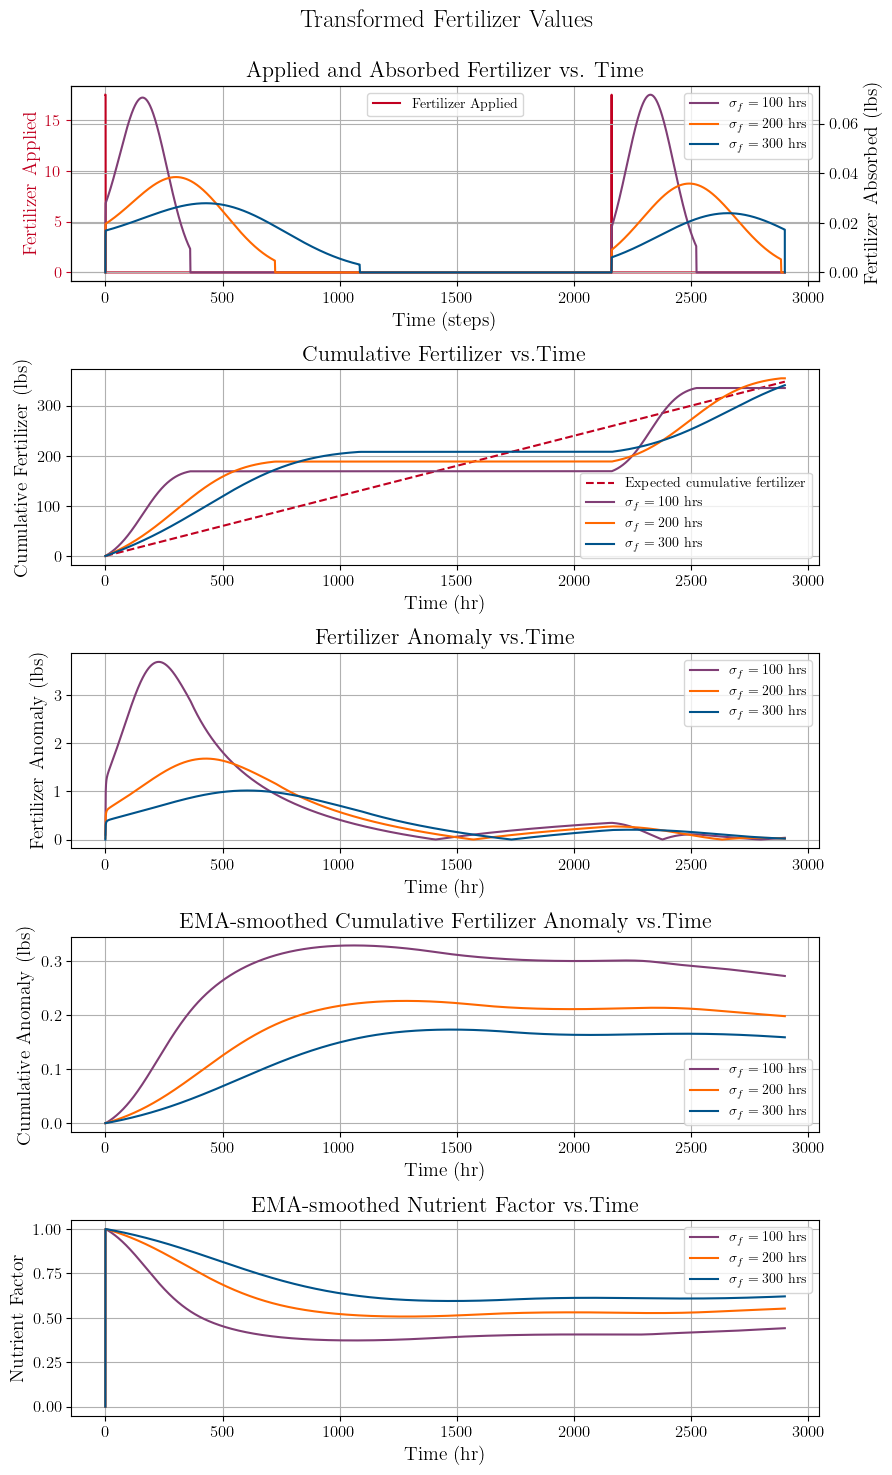

In [9]:
# Setup plotting
from matplotlib import ticker
colors, suptitle_y_position, tight_layout_rect = setup_plotting_styles()
num_subplots = 5
fig, axs = plt.subplots(num_subplots, 1, figsize=(9, num_subplots*3))

def scale_to_hours(x, pos):
    return f'{x * 0.1:g}'  # Multiplies tick value by 0.1 to convert steps to hours

# Raw fertilizer applied + delayed absorption of fertilizer
axs[0].xaxis.set_major_formatter(ticker.FuncFormatter(scale_to_hours)) # Apply the formatter to the x-axis
axs[0].xaxis.set_major_locator(ticker.AutoLocator()) # Ensure ticks appear at reasonable intervals (e.g., every 500 hours / 5000 steps)
axs[0].plot(raw_fertilizer, label='Fertilizer Applied', color=colors.vivid_red)
axs[0].set_xlabel('Time (steps)')
axs[0].set_ylabel('Fertilizer Applied')
axs[0].tick_params(axis='y', colors=colors.vivid_red)
axs[0].yaxis.label.set_color(colors.vivid_red) 
axs[0].set_title('Applied and Absorbed Fertilizer vs. Time')
axs[0].legend(loc="upper center")

ax2 = axs[0].twinx() # Create a second y-axis sharing the same x-axis
ax2.plot(time, delayed_fertilizer_sigmaF_100, label=r'$\sigma_{f} = 100$ hrs', color=colors.strong_purple)
ax2.plot(time, delayed_fertilizer_sigmaF_200, label=r'$\sigma_{f} = 200$ hrs', color=colors.vivid_orange)
ax2.plot(time, delayed_fertilizer_sigmaF_300, label=r'$\sigma_{f} = 300$ hrs', color=colors.strong_blue)
ax2.set_ylabel('Fertilizer Absorbed (lbs)')
ax2.legend()

# Cumulative absorbed fertilizer
axs[1].xaxis.set_major_formatter(ticker.FuncFormatter(scale_to_hours))
axs[1].xaxis.set_major_locator(ticker.AutoLocator())
axs[1].plot(time, expected_cumulative_fertilizer,   label='Expected cumulative fertilizer', linestyle='--', color=colors.vivid_red)
axs[1].plot(time, cumulative_fertilizer_sigmaF_100, label=r'$\sigma_{f} = 100$ hrs', color=colors.strong_purple)
axs[1].plot(time, cumulative_fertilizer_sigmaF_200, label=r'$\sigma_{f} = 200$ hrs', color=colors.vivid_orange)
axs[1].plot(time, cumulative_fertilizer_sigmaF_300, label=r'$\sigma_{f} = 300$ hrs', color=colors.strong_blue)
axs[1].set_xlabel('Time (hr)')
axs[1].set_ylabel('Cumulative Fertilizer (lbs)')
axs[1].set_title(f'Cumulative Fertilizer vs.Time')
axs[1].grid(True)
axs[1].legend()

# Difference between actual and expected cumulative fertilizer ("anomaly")
axs[2].xaxis.set_major_formatter(ticker.FuncFormatter(scale_to_hours))
axs[2].xaxis.set_major_locator(ticker.AutoLocator())
axs[2].plot(time, fertilizer_anomaly_sigmaF_100, label=r'$\sigma_{f} = 100$ hrs', color=colors.strong_purple)
axs[2].plot(time, fertilizer_anomaly_sigmaF_200, label=r'$\sigma_{f} = 200$ hrs', color=colors.vivid_orange)
axs[2].plot(time, fertilizer_anomaly_sigmaF_300, label=r'$\sigma_{f} = 300$ hrs', color=colors.strong_blue)
axs[2].set_xlabel('Time (hr)')
axs[2].set_ylabel('Fertilizer Anomaly (lbs)')
axs[2].set_title(f'Fertilizer Anomaly vs.Time')
axs[2].grid(True)
axs[2].legend()

# EMA-smoothed cumulative anomaly
axs[3].xaxis.set_major_formatter(ticker.FuncFormatter(scale_to_hours))
axs[3].xaxis.set_major_locator(ticker.AutoLocator())
axs[3].plot(time, fertilizer_divergence_sigmaF_100, label=r'$\sigma_{f} = 100$ hrs', color=colors.strong_purple)
axs[3].plot(time, fertilizer_divergence_sigmaF_200, label=r'$\sigma_{f} = 200$ hrs', color=colors.vivid_orange)
axs[3].plot(time, fertilizer_divergence_sigmaF_300, label=r'$\sigma_{f} = 300$ hrs', color=colors.strong_blue)
axs[3].set_xlabel('Time (hr)')
axs[3].set_ylabel('Cumulative Anomaly (lbs)')
axs[3].set_title(f'EMA-smoothed Cumulative Fertilizer Anomaly vs.Time')
axs[3].grid(True)
axs[3].legend()

# EMA-smoothed nutrient factors
axs[4].xaxis.set_major_formatter(ticker.FuncFormatter(scale_to_hours))
axs[4].xaxis.set_major_locator(ticker.AutoLocator())
axs[4].plot(time, nuF_sigmaF_100, label=r'$\sigma_{f} = 100$ hrs', color=colors.strong_purple)
axs[4].plot(time, nuF_sigmaF_200, label=r'$\sigma_{f} = 200$ hrs', color=colors.vivid_orange)
axs[4].plot(time, nuF_sigmaF_300, label=r'$\sigma_{f} = 300$ hrs', color=colors.strong_blue)
axs[4].set_xlabel('Time (hr)')
axs[4].set_ylabel('Nutrient Factor')
axs[4].set_title(f'EMA-smoothed Nutrient Factor vs.Time')
axs[4].grid(True)
axs[4].legend()

fig.suptitle(f'Transformed Fertilizer Values', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()